### Climate change velocity

Step 1: define some metrics to characterize the distribution like the zero growth isoline or peak krill growth potential isoline.

Step 2: Take the latitudinal position of the metric and plot it as a time series

Step 3: Compute the velocity: the distance between where it ends up and where it started and then divide by the amount of time and you have a velocity



#### Krill Distribution Metrics

In [ ]:
from itertools import product

import numpy as np
import xarray as xr

import pop_tools
import xpersist as xp

import util

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar 
from matplotlib import ticker, cm
from matplotlib.ticker import FormatStrFormatter

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean as cmo

plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')

## Grid Things!

In [2]:
grid = pop_tools.get_grid('POP_gx1v6')
#grid
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
grid = grid.isel(nlat=lat_slice)
#grid

#### Regions:
1. Atlantic /Basin: 50°W to 30°E
2. SW Atlantic sector: 30°W to 70°W
* eastern (30–50 W)
* western (50–70 W) 
* SW Atlantic-Peninsula (10 to 80°W)
5. Indian: 30E - 160E
6. Paciﬁc: 160E - 30W


In [3]:
# define a list of tuples describing our regions: (region_name, logical_array)
so_logic = (grid.TLAT <= -45)
mask_logic = [
    ('Southern Ocean', so_logic), 
    ('Atlantic Basin', so_logic & ((grid.TLONG > 310) | (grid.TLONG < 30))), # 50W to 30E
    ('SW Atlantic', so_logic & ((grid.TLONG > 290) | (grid.TLONG < 30))),  # 70W - 30E
    
    ('SW Eastern', so_logic & ((grid.TLONG < 330) & (grid.TLONG > 310))), #30W (310) - 50W (330) # # 30 - 70 70+180 = 250 // 30+180 = 210
    ('SW Western', so_logic & ((grid.TLONG < 330) & (grid.TLONG > 290))), #50W (330) - 70W (290) # # 30 - 70 70+180 = 250 // 30+180 = 210
    ('SW AP', so_logic & ((grid.TLONG < 350) & (grid.TLONG > 280))),   # 10W (350) to 80°W (280)  
]
# create a region coordinate with the region names
region = xr.DataArray(
    [t[0] for t in mask_logic], 
    dims=('region'), 
)
nregion = len(region)

# create a masked array array
masked_area = xr.DataArray(
    np.zeros((nregion,)+grid.TLAT.shape), 
    dims=('region',)+grid.TLAT.dims,
    coords={'region': region},
    name='masked_area',
)
for i, name_logic in enumerate(mask_logic):
    masked_area.data[i, :, :] = grid.TAREA.where(name_logic[1]).fillna(0.).where(grid.KMT>0)

# subset to the lat range from above
masked_area = masked_area.isel(nlat=lat_slice)
#masked_area  

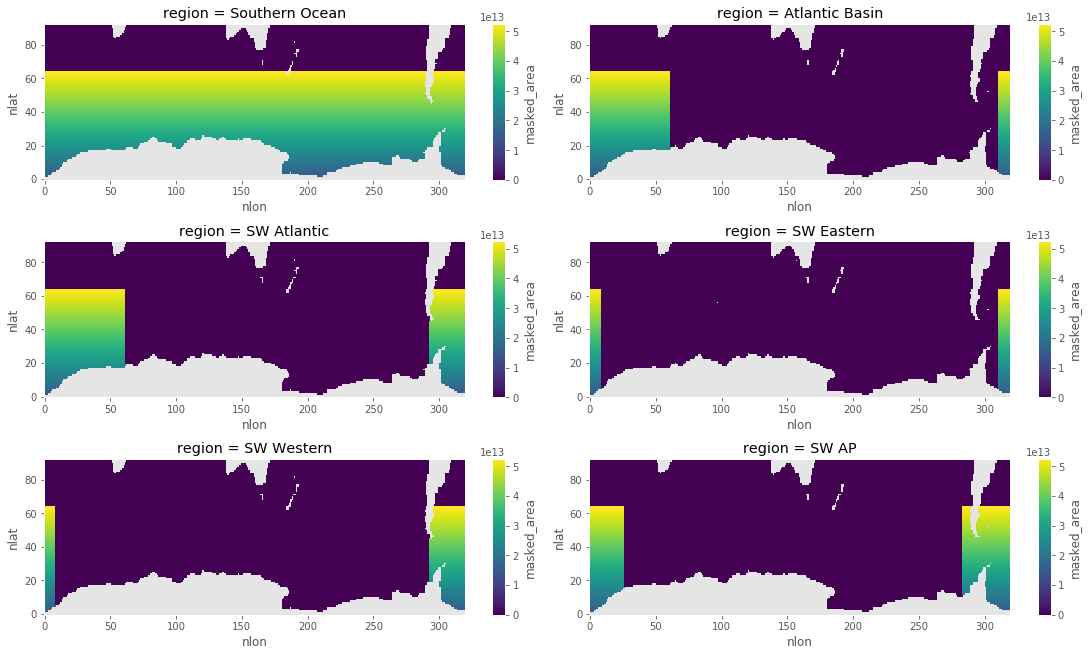

In [4]:
# Check and see if it worked:
ncol = int(np.sqrt(nregion))
nrow = int(nregion/ncol) + min(1, nregion%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(15, 3*nrow),
                       constrained_layout=True)

for i, region in enumerate(masked_area.region.values):
    plt.axes(ax.ravel()[i])
    masked_area.sel(region=region).plot()
    plt.savefig('figures/regions-recalc-plot-t.png', transparent = True)

## Load Data

In [2]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP']].sel(length = 40).where(ds_djf.TLAT <= -45)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
    length     float64 40.0
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

Reduce the dimensionality. Looking at the half polar diagrams, what you could do is take each column in this plot, and then interpolate a particular… Just use linear interpolation defined by your reference point of interest. The growth potential on you might pick zero or some other reference. So you pick zero, and loop over the columns in that plot and find the latitude of each interpolate the latitude at each zero. Just use numpy interp. To extract that latitude.

What you should do is construct a time series of the latitude position of the zero growth contour for each ensemble member for the entire integration: Use linear interpolation to pick out the latitude in a continuous sense given that you know the value of that function at the model grid points, so interpolate between the model grid points. Based on linear interpolations exactly 0 or whatever value you pick. And then you can plot and entire time series of the full ensemble that is the latitude of zero growth potential. And so you would just use some zonal mean over whatever sector you choose.

Then you can plot that latitude as a function of time for every ensemble member and then you can do statistics on it, you can do a TOE calculation and you can compete a trend which is that the unit of the trend would be degrees latitude overtime. For reference 1° and latitude is 111 km so you can actually have a distance for time which gives you velocity the trend is the velocity


##### Select and work with a single EM

In [3]:
ds_17 = ds_djf.sel(member_id = 17)
ds_17

<xarray.Dataset>
Dimensions:    (nlat: 93, nlon: 320, time: 180)
Coordinates:
    length     float64 40.0
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    member_id  int64 17
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, nlat, nlon) float64 dask.array<chunksize=(180, 93, 320), meta=np.ndarray>
    Chl_surf   (time, nlat, nlon) float64 dask.array<chunksize=(180, 93, 320), meta=np.ndarray>
    KGP        (time, nlat, nlon) float64 dask.array<chunksize=(180, 93, 320), meta=np.ndarray>

In [61]:
ds_2020 = ds_17.sel(time = 2020)
ds_2020

<xarray.Dataset>
Dimensions:    (nlat: 93, nlon: 320)
Coordinates:
    length     float64 40.0
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    time       int64 2020
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    member_id  int64 17
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    Chl_surf   (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KGP        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>

In [20]:
da = ds_17.KGP
time = ds_17.time

lat_of_kgp0 = [] 

da

<xarray.DataArray 'KGP' (time: 180, nlat: 93, nlon: 320)>
dask.array<getitem, shape=(180, 93, 320), dtype=float64, chunksize=(180, 93, 320), chunktype=numpy.ndarray>
Coordinates:
    length     float64 40.0
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    member_id  int64 17
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Daily growth rate
    notes:      computed using raw model field
    units:      mm d$^{-1}$

In [21]:
range(len(time))

range(0, 180)

In [28]:
ds_17.KGP.interp()

<xarray.DataArray 'KGP' (time: 180, nlat: 93, nlon: 320)>
dask.array<copy, shape=(180, 93, 320), dtype=float64, chunksize=(180, 93, 320), chunktype=numpy.ndarray>
Coordinates:
    length     float64 40.0
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    member_id  int64 17
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Daily growth rate
    notes:      computed using raw model field
    units:      mm d$^{-1}$

In [34]:
KGP = ds_17.KGP
TLAT = ds_17.TLAT
kgp0 = ds_17.where(ds_17['KGP']==0)

In [37]:
TLAT.shape

(93, 320)

In [36]:
KGP.shape

(180, 93, 320)

In [39]:
range( len(ds_17.time) )

range(0, 180)

In [66]:
#ds_2020.KGP.shape
ds_2020.TLAT.shape

(93, 320)

In [64]:
#-- Label Southern Ocean
lat_i = np.interp(0, ds_2020.KGP.values, ds_2020.TLAT.values)

ValueError: object too deep for desired array

In [55]:
for l in (ds_17.time.values):
    lat_i = np.interp(kgp0, KGP[l].values, TLAT)
    
    lat_of_kgp0.append(lat_i)

IndexError: index 1921 is out of bounds for axis 0 with size 180

In [38]:
for l in range(len(time)):
    lat_i = np.interp(kgp0, KGP, TLAT)
    
    lat_of_kgp0.append(lat_i)

ValueError: object too deep for desired array